In [3]:
import torch
import numpy as np
dirpath = "/mnt/storage/spffn/metrics/inferences/mlp/"

In [6]:
import numpy as np
import torch

def analyze_sign_distribution(embeddings):
    """
    Calculate the average relative distribution of positive vs negative elements in a list of embeddings.

    Args:
        embeddings: List of embedding tensors or numpy arrays

    Returns:
        dict: Contains percentages of positive, negative, and zero values
    """
    positive_percentages = []
    negative_percentages = []
    zero_percentages = []

    for embedding in embeddings:
        # Convert to numpy if it's a torch tensor
        if isinstance(embedding, torch.Tensor):
            embedding = embedding.cpu().to(torch.float16).numpy()

        # Count positive, negative, and zero elements
        total_elements = embedding.size
        positive_count = np.sum(embedding > 0)
        negative_count = np.sum(embedding < 0)
        zero_count = np.sum(embedding == 0)

        # Calculate percentages
        positive_percentages.append(positive_count / total_elements * 100)
        negative_percentages.append(negative_count / total_elements * 100)
        zero_percentages.append(zero_count / total_elements * 100)

    # Calculate averages across all embeddings
    avg_positive = np.mean(positive_percentages)
    avg_negative = np.mean(negative_percentages)
    avg_zero = np.mean(zero_percentages)

    return {
        "positive_percentage": avg_positive,
        "negative_percentage": avg_negative,
        "zero_percentage": avg_zero,
        "positive_to_negative_ratio": avg_positive / avg_negative if avg_negative > 0 else float('inf')
    }

def find_percentile_threshold(embeddings, percentile):
    """
    Find the average value at the bottom of a specific percentile across embeddings.

    Args:
        embeddings: List of embedding tensors or numpy arrays
        percentile: Percentile value (0-100)

    Returns:
        dict: Contains threshold values for absolute, positive-only, and negative-only distributions
    """
    abs_thresholds = []
    pos_thresholds = []
    neg_thresholds = []

    for embedding in embeddings:
        # Convert to numpy if it's a torch tensor
        if isinstance(embedding, torch.Tensor):
            embedding = embedding.cpu().to(torch.float16).numpy()

        # Absolute value threshold
        abs_threshold = np.percentile(np.abs(embedding), percentile)
        abs_thresholds.append(abs_threshold)

        # Positive values threshold
        positive_values = embedding[embedding > 0]
        if len(positive_values) > 0:
            pos_threshold = np.percentile(positive_values, percentile)
            pos_thresholds.append(pos_threshold)

        # Negative values threshold (absolute values of negatives)
        negative_values = np.abs(embedding[embedding < 0])
        if len(negative_values) > 0:
            neg_threshold = np.percentile(negative_values, percentile)
            neg_thresholds.append(neg_threshold)

    return {
        "absolute_threshold": np.mean(abs_thresholds),
        "positive_threshold": np.mean(pos_thresholds) if pos_thresholds else None,
        "negative_threshold": np.mean(neg_thresholds) if neg_thresholds else None
    }

In [13]:
dists = {x: [] for x in range(32)}
at = {x: [] for x in range(32)}
pt = {x: [] for x in range(32)}
nt = {x: [] for x in range(32)}

for i in range(10):
    data = torch.load(dirpath + f"prompt_{i}.pt")
    for l in range(32):
        embeddings = [data[l][j]["act_fn output"] for j in range(len(data[l]))]
        dist = analyze_sign_distribution(embeddings)
        dists[l].append((dist["positive_percentage"], dist["negative_percentage"]))
        threshold_55 = find_percentile_threshold(embeddings, 55)
        threshold_50 = find_percentile_threshold(embeddings, 50)
        threshold_45 = find_percentile_threshold(embeddings, 45)
        at[l].append((threshold_45["absolute_threshold"], threshold_50["absolute_threshold"], threshold_55["absolute_threshold"]))
        pt[l].append((threshold_45["positive_threshold"], threshold_50["positive_threshold"], threshold_55["positive_threshold"]))
        nt[l].append((threshold_45["negative_threshold"], threshold_50["negative_threshold"], threshold_55["negative_threshold"]))

In [ ]:
import torch
import numpy as np
dists = torch.load("./dists.pt", weights_only=False)
for l in range(32):
    print(dists[l][0])

0.4968164836778308
0.5092171432218451
0.4259630764984282
0.34976723768119183
0.25754454909240626
0.2525781837463433
0.26019552105801574
0.28290012746448584
0.27453769559032726
0.27275198992345484
0.2714954550645071
0.28652163085641724
0.3082619626667153
0.2806060010540702
0.276574903940766
0.23340058417898762
0.24202669716285788
0.23510609885328812
0.2502050736166592
0.2627874738635099
0.27805937524551166
0.2743976393942475
0.30441055375600534
0.34112365647037085
0.3806217064575252
0.3812566540931405
0.3796631680250218
0.36088130734217116
0.35269949106263526
0.40319109498285277
0.42502314196430235
0.6854815183853542


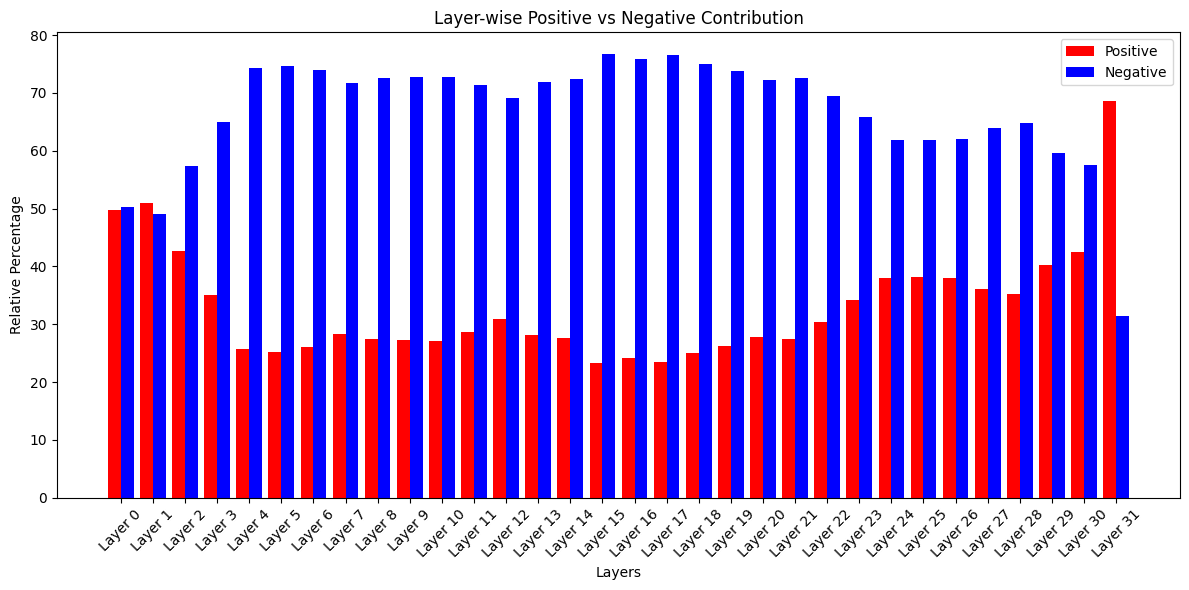

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
values = [
    0.4968164836778308, 0.5092171432218451, 0.4259630764984282, 0.34976723768119183,
    0.25754454909240626, 0.2525781837463433, 0.26019552105801574, 0.28290012746448584,
    0.27453769559032726, 0.27275198992345484, 0.2714954550645071, 0.28652163085641724,
    0.3082619626667153, 0.2806060010540702, 0.276574903940766, 0.23340058417898762,
    0.24202669716285788, 0.23510609885328812, 0.2502050736166592, 0.2627874738635099,
    0.27805937524551166, 0.2743976393942475, 0.30441055375600534, 0.34112365647037085,
    0.3806217064575252, 0.3812566540931405, 0.3796631680250218, 0.36088130734217116,
    0.35269949106263526, 0.40319109498285277, 0.42502314196430235, 0.6854815183853542
]

# Creating tuples (x, 1-x)
tuples_list = [(x, 1 - x) for x in values]

# Extracting data
indices = np.arange(len(tuples_list))  # X-axis positions
positives = [t[0] * 100 for t in tuples_list]  # Convert to percentage
negatives = [t[1] * 100 for t in tuples_list]

# Plot
width = 0.4  # Width of the bars
fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(indices - width/2, positives, width, color='red', label='Positive')
ax.bar(indices + width/2, negatives, width, color='blue', label='Negative')

# Labels and titles
ax.set_xlabel("Layers")
ax.set_ylabel("Relative Percentage")
ax.set_title("Layer-wise Positive vs Negative Element Distribution")
ax.set_xticks(indices)
ax.set_xticklabels([f"Layer {i}" for i in range(len(tuples_list))], rotation=45)
ax.legend()

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
for layer in mean_sims:
    print(f"Mean cosine similarity of layer {layer} is {np.mean(mean_sims[layer])}")

Mean cosine similarity of layer 0 is 0.281005859375
Mean cosine similarity of layer 1 is 0.671875
Mean cosine similarity of layer 2 is 0.740234375
Mean cosine similarity of layer 3 is 0.81982421875
Mean cosine similarity of layer 4 is 0.8154296875
Mean cosine similarity of layer 5 is 0.78515625
Mean cosine similarity of layer 6 is 0.8046875
Mean cosine similarity of layer 7 is 0.80810546875
Mean cosine similarity of layer 8 is 0.82861328125
Mean cosine similarity of layer 9 is 0.83740234375
Mean cosine similarity of layer 10 is 0.849609375
Mean cosine similarity of layer 11 is 0.841796875
Mean cosine similarity of layer 12 is 0.818359375
Mean cosine similarity of layer 13 is 0.84326171875
Mean cosine similarity of layer 14 is 0.84326171875
Mean cosine similarity of layer 15 is 0.85400390625
Mean cosine similarity of layer 16 is 0.88134765625
Mean cosine similarity of layer 17 is 0.8916015625
Mean cosine similarity of layer 18 is 0.91796875
Mean cosine similarity of layer 19 is 0.933105

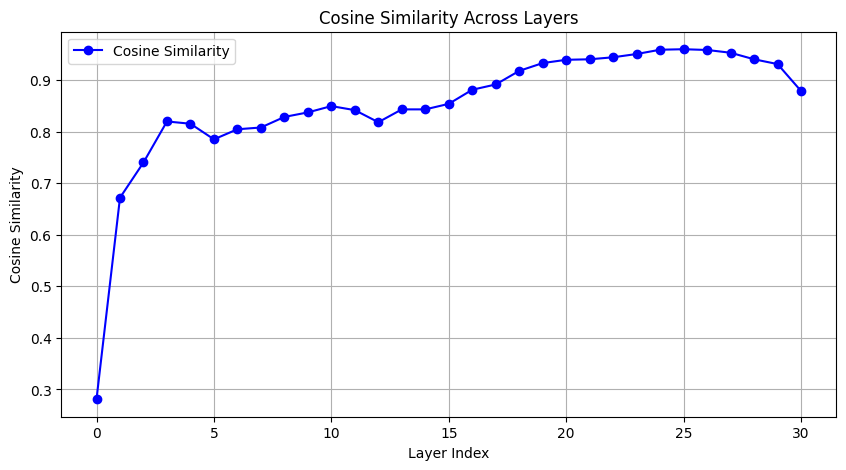

In [1]:
import matplotlib.pyplot as plt

# Cosine similarity values
cosine_similarities = [
    0.281005859375, 0.671875, 0.740234375, 0.81982421875, 0.8154296875,
    0.78515625, 0.8046875, 0.80810546875, 0.82861328125, 0.83740234375,
    0.849609375, 0.841796875, 0.818359375, 0.84326171875, 0.84326171875,
    0.85400390625, 0.88134765625, 0.8916015625, 0.91796875, 0.93310546875,
    0.939453125, 0.9404296875, 0.9443359375, 0.95068359375, 0.958984375,
    0.9599609375, 0.95849609375, 0.953125, 0.9404296875, 0.93115234375,
    0.87890625
]

# Layer indices
layers = list(range(len(cosine_similarities)))

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(layers, cosine_similarities, marker='o', linestyle='-', color='b', label='Cosine Similarity')
plt.xlabel('Layer Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Across Layers')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
cs = {x: np.mean(mean_sims[x]) for x in range(31)}
torch.save(cs, "./cosine_similarities.pt")

In [22]:
import torch

def find_threshold_by_position(x_samples, target_sparsity=0.55, num_thresholds=200):
    n = len(x_samples)
    stacked_samples = torch.stack(x_samples)
    abs_values = torch.abs(stacked_samples)

    # Define candidate thresholds with a limited number of values
    min_val, max_val = abs_values.min().item(), abs_values.max().item()
    candidate_thresholds = torch.linspace(min_val, max_val, steps=num_thresholds)

    # Binary search for the best threshold
    left, right = 0, len(candidate_thresholds) - 1
    best_threshold = None
    min_diff = float('inf')

    while left <= right:
        mid = (left + right) // 2
        t = candidate_thresholds[mid]

        indicators = (abs_values <= t).float()
        position_probs = torch.mean(indicators, dim=0)  # Average across samples
        overall_prob = torch.mean(position_probs).item()

        diff = abs(overall_prob - target_sparsity)

        if diff < min_diff:
            min_diff = diff
            best_threshold = t.item()

        # Adjust search range
        if overall_prob < target_sparsity:
            left = mid + 1
        else:
            right = mid - 1

    return best_threshold